# Healthcare Employee Attrition Prediction

Explain the dataset, why we are performing predictive modelling, etc.

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

import shap
import matplotlib.pyplot as plt

First thing's first -- we need to understand the data structure and choose relevant features for our predictive modelling.

In [3]:
# Load the dataset into a Pandas dataframe
df = pd.read_csv(r'watson_healthcare_modified.csv')

# Display the first few rows of the data from our newly generated dataframe
df.head()

,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


For predicting healthcare employee attrition, we need to outline a project plan:

1. **Preprocess the Data**: Convert categorical variables to numerical, handle missing values if any, and select relevant features for predicting attrition.
2. **Feature Selection**: Choose features that are likely to influence attrition based on domain knowledge and data exploration. For maximizing the F1 score, we'll focus on features that have a strong relationship with attrition.
3. **Model Training**: Train a machine learning model using the selected features.
4. **Prediction and Evaluation**: Predict attrition and evaluate the model using the F1 score.

For initial feature selection, I chose the following features that would commonly relate to employee attrition:
* Age
* BusinessTravel
* Department
* DistanceFromHome
* EducationField
* JobRole
* MaritalStatus
* MonthlyIncome
* OverTime
* TotalWorkingYears
* WorkLifeBalance
* YearsAtCompany
* YearsSinceLastPromotion
* YearsInCurrentRole

I will need to encode categorial features and use a model well-suited for mixed-type data. I will begin by using a Gradient Boosting Classifier. The features and model used will be reassessed following the output/analysis of our first trial's performance.

### Attempt 1 - Preprocessing, Feature Selection, and Model Training

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

# Preprocessing: Encode categorical variables
label_encoders = {}
for column in ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Convert Attrition to numerical
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Check for NaN values in the target variable and drop rows with NaN values
print(f"NaN values in 'Attrition': {df['Attrition'].isnull().sum()}")
df = df.dropna(subset=['Attrition'])

# Selecting relevant features
features = ['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'EducationField', 
            'JobRole', 'MaritalStatus', 'MonthlyIncome', 'OverTime', 'TotalWorkingYears', 
            'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsInCurrentRole']

X = df[features]
y = df['Attrition']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluate the model using multiple metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Outputting all relevant performance information
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")


NaN values in 'Attrition': 0
Accuracy: 0.8958333333333334
Precision: 0.7142857142857143
Recall: 0.425531914893617
F1 Score: 0.5333333333333333
Confusion Matrix:
[[281   8]
 [ 27  20]]


Our first results are in! Let's analyze them before diving into any tuning or additional modelling:

#### Accuracy: 89.58%
In our test data, we correctly predicted whether a healthcare employee would leave or stay at their job in <i>almost</i> 90% of cases. This sounds great at face value, but judging our model's performance based on accuracy alone would be misleading, especially when datasets are imbalanced (i.e. a certain demographic of healthcare employee is far more represented in the dataset). Let's dive into the other parameters for a better picture.

#### Precision: 71.43%
When the model predicted a healthcare employee would leave, it was correct about 71% of the time. If our healthcare company decided to increase spending to keep healthcare employees that were predicted to leave, false positives would prove very costly, which is a good reason to improve our performance in this area.

#### Recall: 42.55%
The model correctly identified 42.55% of all employees who actually left. In other words, our model missed more than half of the actual attrition cases in the test data. This suggests that the model is relatively conservative when predicting a healthcare employee will leave. If our healthcare company wants to identify as many true cases of attrition as possible for prevention measures, a low recall score like this would be a concern.

#### F1 Score: 55.33%
The F1 score is my personal favorite performance metric for machine learning models, as it illustrates the harmonic mean of precision and recall so that we may assess the balance between them. At 55.33%, I would say that this model has a moderate balance between the two, with solid room foor improvement. Our best case scenario is to improve recall without significantly sacrificing precision. 

#### Confusion Matrix: 
```
[[281   8]
[ 27  20]]
 ```

 This provides a numerical breakdown of the model's predictions:
* <b>True Negatives (TN): 281</b> - The model correctly predicted that 281 employees would stay.
* <b>False Positives (FP): 8</b> - The model incorrectly predicted that 8 employees would leave (but they stayed).
* <b>False Negatives (FN): 27</b> - The model incorrectly predicted that 27 employees would stay (but they left).
* <b>True Positives (TP): 20</b> - The model correctly predicted that 20 employees would leave.

This further illustrates my point that our model is quite conservative when prediction attrition right now. This is evident due to the higher number of false negatives than false positives, which aligns with the lower recall score.


### Attempt 2 - Hyperparameter Tuning (Mixed Automated and Manual Methods)
This time, I performed a comprehensive grid search over a specified range of hyperparameters for the Gradient Boosting Classifier. This search had various values for the learning rate, maximum depth of the trees, and the number of estimators.

The goal was to find the optimal combination of parameters that maximizes the F1 score, for which I utilized GridSearchCV. To ensure robustness, I evaluated across 4-fold cross-validation. I manually tweaked the test_size and random_state as well (somewhat arbitrarily) and assessed the performance number output.

**WARNING**: Running this code is <i>EXTREMELY</i> CPU intensive!! This is only intended to be run on a powerful computer for finding the best tuning configuration! After we have these hyperparameters set, there's no need to perform the grid search each time.

In [5]:
# Required libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Load the dataset
df = pd.read_csv(r'watson_healthcare_modified.csv')

# Encode categorical variables and prepare features and target
label_encoders = {}
categorical_columns = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

features = ['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'EducationField', 
            'JobRole', 'MaritalStatus', 'MonthlyIncome', 'OverTime', 'TotalWorkingYears', 
            'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsInCurrentRole']
X = df[features]
y = df['Attrition']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=40)

# Hyperparameter tuning for Gradient Boosting Classifier
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 10],
    'learning_rate': [0.1, 0.15, 0.05, 0.01, 0.001, 0.2, 0.25]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=40), param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

# Making predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model using multiple metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Outputting all relevant performance information
print(f"Best parameters: {best_params}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Note: Replace 'path_to_your_data/watson_healthcare_modified.csv' with the actual path to your dataset.


Best parameters: {'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 150}
Accuracy: 0.9108910891089109
Precision: 0.7272727272727273
Recall: 0.5714285714285714
F1 Score: 0.64
Confusion Matrix:
[[168   6]
 [ 12  16]]


Using the best parameters found ({'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 150}), the model demonstrated clear improvement in its ability to predict employee attrition!
Performance metrics were calculated, showing enhanced accuracy (91.09%), precision (72.73%), recall (57.14%), and F1 score (0.64), indicating a more balanced trade-off between precision and recall compared to previous attempts.
The confusion matrix revealed that the model correctly predicted a significant majority of both positive (attrition) and negative (non-attrition) cases, with relatively few false positives and false negatives.

I would be far more confident implementing this tuning of our model for a phase 1 predictive model.

### Building Valuable Visualizations in Python
Executive decision makers would be far more interested in learning what the most important factors (positive or negative) are for influencing employee attrition than they would be learning about the model's f1 score! Now it's time for me to turn our model's construction into meaningful, visual insights.

I am going to calculate SHAP values (SHapley Additive exPlanations values) for the Gradient Boosting Classifier model and then plot them. This visualization allows us to interpret the contribution of each feature to our model's prediction for an individual instance.  In practice, we would likely undergo a few more trials of model/training data improvement before presenting a visualization like this (because this visualization is only as meaningful as your model is correct), but I am going to do it now for the sake of demonstrating how it can be done.

The code will output the data for an employee followed by the horizontal bar graph showing how heavily the ML model considered each feature in determining that employee's attrition outcome. I chose three random employees so that we can compare the decision-making process in the prediction for each case.


#### #1 - Horizontal Bar Chart of SHAP Values

Data for employee at index 4:
Age                           60
BusinessTravel                 2
Department                     1
DistanceFromHome               1
EducationField                 3
JobRole                        2
MaritalStatus                  0
MonthlyIncome              10883
OverTime                       0
TotalWorkingYears             19
WorkLifeBalance                4
YearsAtCompany                 1
YearsSinceLastPromotion        0
YearsInCurrentRole             0
Name: 1206, dtype: int64


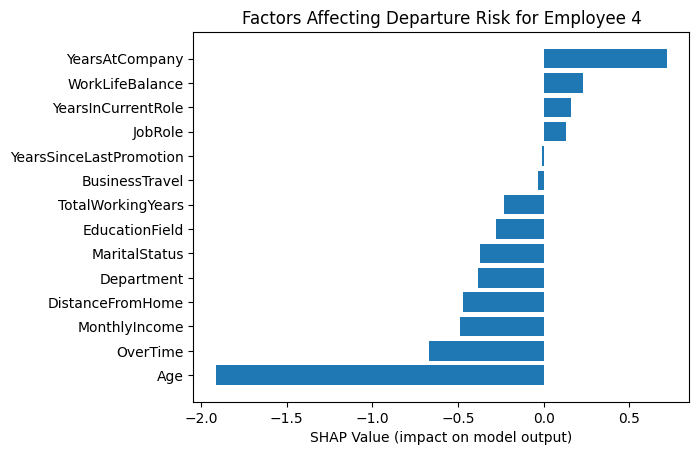

Data for employee at index 10:
Age                          50
BusinessTravel                2
Department                    2
DistanceFromHome             28
EducationField                3
JobRole                       2
MaritalStatus                 1
MonthlyIncome              3221
OverTime                      1
TotalWorkingYears            20
WorkLifeBalance               3
YearsAtCompany               20
YearsSinceLastPromotion       3
YearsInCurrentRole            8
Name: 1626, dtype: int64


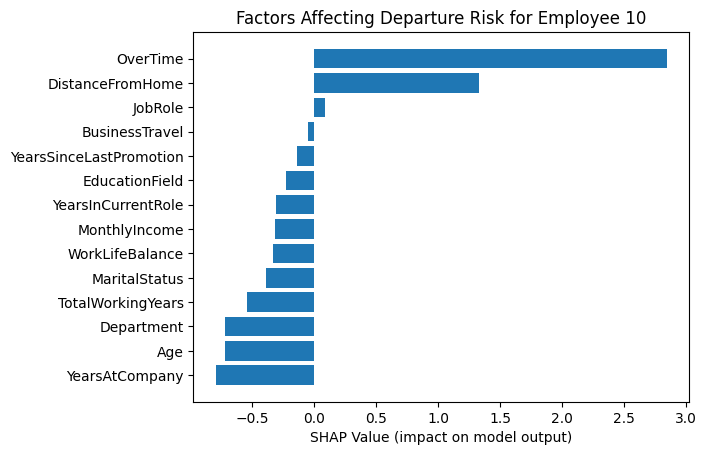

Data for employee at index 15:
Age                          35
BusinessTravel                1
Department                    0
DistanceFromHome             18
EducationField                2
JobRole                       2
MaritalStatus                 1
MonthlyIncome              4614
OverTime                      1
TotalWorkingYears             5
WorkLifeBalance               2
YearsAtCompany                4
YearsSinceLastPromotion       3
YearsInCurrentRole            2
Name: 978, dtype: int64


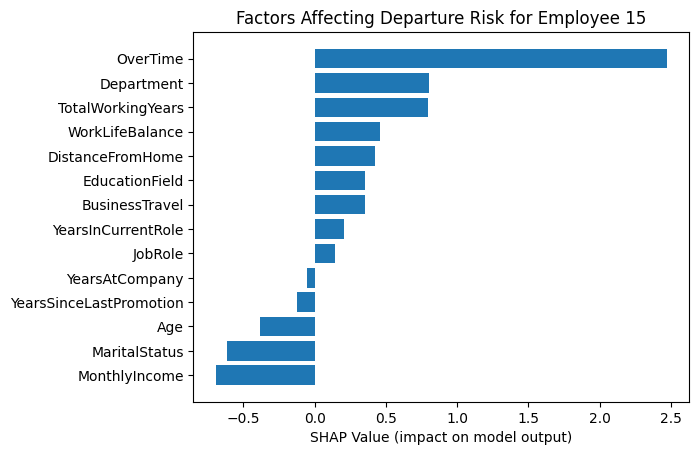

In [14]:
# Calculate SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Define a list of indexes for the instances you want to visualize
indexes_to_visualize = [4, 10, 15]  # Replace with the actual indexes of employees you want to analyze

# Iterate over each index to visualize and print data
for index_to_visualize in indexes_to_visualize:
    # Output the data for this employee so we can understand why/how the model might weigh certain factors
    employee_data = X_test.iloc[index_to_visualize]
    print(f"Data for employee at index {index_to_visualize}:")
    print(employee_data)
    
    # Make a bar plot for SHAP values for a single instance
    shap_values_instance = shap_values[index_to_visualize]
    feature_names = X_test.columns
    shap_values_sorted, feature_names_sorted = zip(*sorted(zip(shap_values_instance, feature_names)))

    plt.figure()
    plt.barh(range(len(shap_values_sorted)), shap_values_sorted, tick_label=feature_names_sorted)
    plt.xlabel('SHAP Value (impact on model output)')
    plt.title(f'Factors Affecting Departure Risk for Employee {index_to_visualize}')
    plt.show()


One thing I immediately notice is that the SHAP Value for Age becomes VERY negative for the employee that is 60 vs. the employees at age 50/35. According to the output, this older age contributes to a lower risk of the employee leaving the company when our model makes its prediction.